# Simulation and Noise Models

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.insert(0, '../')

We can set up a noise model, following the [Qiskit textbook](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html#Correcting-errors-in-qubits). We define our noise model to have equal chances of X and Z:

In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_err):

    error_gate1 = pauli_error([('X', p_err/2), ('Z', p_err/2), ('I', 1 - p_err)])
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [5]:
from qiskit import execute, Aer
from surface_code.circuits import SurfaceCode
from surface_code.fitters import GraphDecoder

We set up a test harness to run through some examples:

In [8]:
def full_loop(code, decoder_simulated, decoder_analytic, noise_model=None):
    # noise_model = get_noise(0.01)
    counts = execute(code.circuit['0'], Aer.get_backend('qasm_simulator'), shots=1, noise_model=noise_model).result().get_counts()
    X_errors, Z_errors = code.extract_nodes(code.process_results(counts))

    print("Raw readout:", counts)
    print("Parsed X:", X_errors)
    print("Parsed Z:", Z_errors)
    
    # Analytic Decoder
    flips = {}
    for error_key,errors in dict(zip(("X", "Z"), (X_errors,Z_errors))).items():
        if errors:
            error_graph, paths = decoder_analytic.make_error_graph(errors, error_key)
            matching_graph = decoder_analytic.matching_graph(error_graph,error_key)
            matches = decoder_analytic.matching(matching_graph,error_key)
            flips[error_key] = decoder_analytic.calculate_qubit_flips(matches, paths,error_key)
        else:
            flips[error_key] = {}
    print("----------------")
    print("Decoder results (analytic):")
    print(decoder_analytic.net_qubit_flips(flips["X"], flips["Z"]))

    
    # Simulated Decoder 
    flips = {}
    for error_key,errors in dict(zip(("X", "Z"), (X_errors,Z_errors))).items():
        if errors:
            error_graph = decoder_simulated.make_error_graph(errors, error_key)#when using a simulated syndrome graph, make_error_graph will only return error_graph
            matching_graph = decoder_simulated.matching_graph(error_graph,error_key)
            matches = decoder_simulated.matching(matching_graph,error_key)
            paths = decoder_simulated.analytic_paths(matches,error_key) #simulated syndrome graph does not have nearest neighbor edges that allow for proper error chain determination
            flips[error_key] = decoder_simulated.calculate_qubit_flips(matches, paths,error_key)
        else:
            flips[error_key] = {}
    print("----------------")
    print("Decoder results (simulated):")
    print(decoder_simulated.net_qubit_flips(flips["X"], flips["Z"]))

In [9]:
code = SurfaceCode(3, 3)
decoder_simulated = GraphDecoder(3, 3, simulation=True)
decoder_analytic = GraphDecoder(3, 3)

We can compare `decoder1`, the syndrome graph from simulation, with `decoder2`, the analytic graph:

In [10]:
for i in range(10):
    print("====Run", i, "====")
    full_loop(code, decoder_simulated, decoder_analytic)
    print("=============", "\n")

====Run 0 ====
Raw readout: {'011101101 00100100 00100100 00100100': 1}
Parsed X: []
Parsed Z: []
----------------
Decoder results (analytic):
{}
----------------
Decoder results (simulated):
{}

====Run 1 ====
Raw readout: {'110110110 00000001 00000001 00000001': 1}
Parsed X: []
Parsed Z: []
----------------
Decoder results (analytic):
{}
----------------
Decoder results (simulated):
{}

====Run 2 ====
Raw readout: {'101011000 10000101 10000101 10000101': 1}
Parsed X: []
Parsed Z: []
----------------
Decoder results (analytic):
{}
----------------
Decoder results (simulated):
{}

====Run 3 ====
Raw readout: {'011011000 00100100 00100100 00100100': 1}
Parsed X: []
Parsed Z: []
----------------
Decoder results (analytic):
{}
----------------
Decoder results (simulated):
{}

====Run 4 ====
Raw readout: {'000000000 00000000 00000000 00000000': 1}
Parsed X: []
Parsed Z: []
----------------
Decoder results (analytic):
{}
----------------
Decoder results (simulated):
{}

====Run 5 ====
Raw r

And now run with some noise:

In [19]:
for i in range(10):
    print("====Run", i, "====")
    full_loop(code, decoder_simulated, decoder_analytic, noise_model=get_noise(0.05))
    print("=============", "\n")

====Run 0 ====
Raw readout: {'101100111 10011010 10000001 10000000': 1}
Parsed X: [(1, 2.5, 1.5), (2, 2.5, 1.5)]
Parsed Z: [(2, 0.5, 2.5), (2, 1.5, -0.5), (2, 1.5, 1.5)]
----------------
Decoder results (analytic):
{(2.0, 0.0): array([[ 1,  0],
       [ 0, -1]]), (1.0, 2.0): array([[ 1,  0],
       [ 0, -1]])}
----------------
Decoder results (simulated):
{(2.0, 0.0): array([[ 1,  0],
       [ 0, -1]]), (1.0, 2.0): array([[ 1,  0],
       [ 0, -1]])}

====Run 1 ====
Raw readout: {'110101011 00111011 00111111 00101011': 1}
Parsed X: [(1, 1.5, 0.5), (2, 1.5, 0.5)]
Parsed Z: [(1, 0.5, 2.5)]
----------------
Decoder results (analytic):
{(0.0, 2.0): array([[ 1,  0],
       [ 0, -1]])}
----------------
Decoder results (simulated):
{(0.0, 2.0): array([[ 1,  0],
       [ 0, -1]])}

====Run 2 ====
Raw readout: {'101000011 10010101 10110100 10000001': 1}
Parsed X: [(1, 0.5, 1.5), (1, 1.5, 0.5), (1, 2.5, 1.5), (2, 0.5, 1.5), (2, 2.5, 1.5)]
Parsed Z: [(1, 0.5, 2.5)]
----------------
Decoder result

# Logical Error Rate Graphs

In [6]:
from surface_code.benchmarking import SurfaceCodeBenchmarkingTool

In [9]:
decoder = GraphDecoder(5,3) 
tool = SurfaceCodeBenchmarkingTool()
tool.logical_error_rate(decoder, {"1 00000000 00000000":40}, 1)

0.0

In [10]:
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister, Aer

data = QuantumRegister(9, name='data')
mx = QuantumRegister(4, name='mx')
mz = QuantumRegister(4, name='mz')

rounds=2  # The actual number of rounds will always be more than 1, since the first round creates the quiescent state
measurements = [ClassicalRegister(8, name="c{}".format(i+1)) for i in range(rounds + 1)]
logical = QuantumRegister(1, name="logical")

base_circ = QuantumCircuit(data, mz, mx, *measurements, logical)

def stabilize(circ, i):
    # Top left
    circ.h(mx[0])
    circ.cx(mx[0], data[1])
    circ.cx(mx[0], data[0])
    circ.cx(data[1], mz[0])
    circ.cx(data[0], mz[0])
    circ.cx(data[4], mz[0])
    circ.cx(data[3], mz[0])
    circ.h(mx[0])
    
    # Top right
    circ.h(mx[1])
    circ.cx(mx[1], data[2])
    circ.cx(mx[1], data[1])
    circ.cx(mx[1], data[5])
    circ.cx(mx[1], data[4])
    circ.cx(data[2],mz[1])
    circ.cx(data[5],mz[1])
    circ.h(mx[1])
    
    # Bottom left
    circ.h(mx[2])
    circ.cx(data[3], mz[2])
    circ.cx(data[6], mz[2])
    circ.cx(mx[2], data[4])
    circ.cx(mx[2], data[3])
    circ.cx(mx[2], data[7])
    circ.cx(mx[2], data[6])
    circ.h(mx[2])

    # Bottom right
    circ.h(mx[3])
    circ.cx(mx[3], data[8])
    circ.cx(mx[3], data[7])
    circ.cx(data[5], mz[3])
    circ.cx(data[4], mz[3])
    circ.cx(data[8], mz[3])
    circ.cx(data[7], mz[3])
    circ.h(mx[3])
    circ.barrier()

    circ.measure(mz, measurements[i][0:4])
    circ.measure(mx, measurements[i][4:8])
    circ.reset(mz)
    circ.reset(mx)
    circ.barrier()

def get_stabilized_circ(base_circuit, rounds):
    circ = base_circuit.copy()
    for i in range(rounds + 1):
        stabilize(circ, i)
    return circ

In [11]:
circ = get_stabilized_circ(base_circ, rounds)
logical_zero = circ.copy()

logical_readout = ClassicalRegister(1, name="logicalR")
logical_zero.add_register(logical_readout)

# The Z-logical readout
logical_zero.reset(logical)
logical_zero.cx(data[0], logical)
logical_zero.cx(data[1], logical)
logical_zero.cx(data[2], logical)
logical_zero.measure(logical, logical_readout)

In [17]:
logical = []
noise = [5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 1e-2, 2e-2]
for rate in noise:
    results = execute(logical_zero, Aer.get_backend('qasm_simulator'), noise_model=get_noise(rate), shots=1024).result().get_counts()
    logical.append(tool.logical_error_rate(decoder, results, 0))

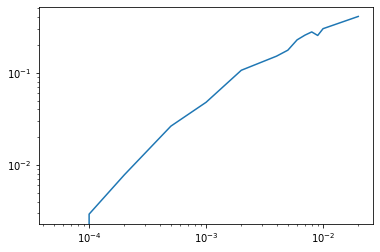

In [18]:
import matplotlib.pyplot as plt
plt.plot(noise, logical)
plt.yscale("log")
plt.xscale("log")

In [19]:
logical

[0.0,
 0.0029296875,
 0.0078125,
 0.0263671875,
 0.0478515625,
 0.1064453125,
 0.1513671875,
 0.17578125,
 0.2275390625,
 0.255859375,
 0.27734375,
 0.25390625,
 0.30078125,
 0.408203125]